In [1]:
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plot
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from numpy import argmax
import cv2
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt

2025-06-11 14:06:31.965288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-11 14:06:31.965431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 14:06:32.099513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Batch_size = 32
Image_size = (96,96)
directory_root_for_RGB_images = '/kaggle/input/eye-diseases-classification/eye_diseases_classification'
input_shape = tuple((96, 96))

In [3]:
#creating image list containing all Dataset images as directories
image_dir_list = []
label_list = []
print("Loading images ...")
#creating alist of the directories of subfiles
root_dir = os.listdir(directory_root_for_RGB_images)
for subfiles1 in root_dir:
    subfiles2 = os.listdir(f"{directory_root_for_RGB_images}/{subfiles1}")
    for image_dir1 in subfiles2:
        image_dir = f"{directory_root_for_RGB_images}/{subfiles1}/{image_dir1}"
        if image_dir.endswith(".jpg") or image_dir.endswith(".JPG") or image_dir.endswith(".png") or image_dir.endswith(".PNG") or image_dir.endswith(".jpeg") or image_dir.endswith(".JPEG"):
                image_dir_list.append(image_dir)
                label_list.append(subfiles1)

Loading images ...


In [4]:
files = os.listdir(directory_root_for_RGB_images)
print(files)

['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']


In [5]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [6]:
def augment_data(X_train, y_train, n_augmentations=5):
    augmented_images = []
    augmented_labels = []
    for i in range(X_train.shape[0]):
        img = X_train[i]
        img = img.reshape((1,) + img.shape)
        for _ in range(n_augmentations):
            for batch in datagen.flow(img, batch_size=1):
                augmented_images.append(batch[0])
                augmented_labels.append(y_train[i])
                break
    return np.array(augmented_images), np.array(augmented_labels)

In [7]:
#importing all images in a list
images_data= []
for image_dir in image_dir_list:
    if image_dir.endswith(".jpg") or image_dir.endswith(".JPG") or image_dir.endswith(".png") or image_dir.endswith(".PNG") or image_dir.endswith(".jpeg") or image_dir.endswith(".JPEG"):
        image = cv2.imread(image_dir)
        image = cv2.resize(image, input_shape)
        image_array = img_to_array(image)
        images_data.append(image_array)

In [8]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)
print(n_classes)

4


In [9]:
#Converting images to numpy array with normalization
np_image_data = np.array(images_data, dtype=np.float16) / 225.0
print(np_image_data.shape)

(4217, 96, 96, 3)


In [10]:
# Convert lists to numpy arrays
X = np.array(np_image_data)
y = np.array(image_labels)

In [11]:
X_train, X_test, y_trian, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [12]:
X_augmented, y_augmented = augment_data(X_train, y_trian)

In [13]:
X_total = np.concatenate((X_train, X_augmented))
y_total = np.concatenate((y_trian, y_augmented))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.3, random_state=42)

In [15]:
print(len(X_train))

12394


In [16]:
print(len(y_train))

12394


In [18]:
#defining base model
base_model = tf.keras.applications.xception.Xception(include_top=False,weights="imagenet",input_shape=(96,96,3))
base_model.trainable = True #updating all layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
prediction_layer = tf.keras.layers.Dense(units= 4, activation='sigmoid')(global_average_layer)
model = tf.keras.models.Model(inputs= base_model.input, outputs=prediction_layer)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [19]:
model.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.RMSprop(learning_rate= 0.0001),metrics=["accuracy"])

In [20]:
#model.summary()

In [21]:
model.fit(X_train,y_train,epochs = 50)

Epoch 1/50
  2/388 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.2031 - loss: 0.7285   

I0000 00:00:1749652429.284928      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1749652429.334624      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


388/388 ━━━━━━━━━━━━━━━━━━━━ 74s 106ms/step - accuracy: 0.6551 - loss: 0.3939
Epoch 2/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9164 - loss: 0.1124
Epoch 3/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9641 - loss: 0.0523
Epoch 4/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9812 - loss: 0.0309
Epoch 5/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9875 - loss: 0.0209
Epoch 6/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9917 - loss: 0.0148
Epoch 7/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9939 - loss: 0.0115
Epoch 8/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9929 - loss: 0.0122
Epoch 9/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9946 - loss: 0.0076
Epoch 10/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9962 - loss: 0.0064
Epoch 11/50
388/388 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.9955 - loss: 0.0072
Epoch 12/50
388/388 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
model.save("Eye diseas classification.h5")

In [22]:

y_pred_train = model.predict(X_train)


y_pred_test =  model.predict(X_test)


y_pred_test = y_pred_test > 0.5
y_pred_train = y_pred_train > 0.5

388/388 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [ ]:
y_test

In [23]:
 def accuracy(y_true, y_pred):
    
    correct_predictions = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == yp:
            
            correct_predictions += 1
    
    #returns accuracy
    return correct_predictions / len(y_true)

In [25]:
print(metrics.accuracy_score(y_test, y_pred_test)*100)
accuracy= metrics.accuracy_score(y_test, y_pred_test)*100

print('Test accuracy is :' + str(accuracy))

96.79969879518072
Test accuracy is :96.79969879518072


In [26]:
m = MultiLabelBinarizer().fit(y_test)

print(classification_report(m.transform(y_test), m.transform(y_pred_test)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5312
           1       1.00      1.00      1.00      5312

   micro avg       1.00      1.00      1.00     10624
   macro avg       1.00      1.00      1.00     10624
weighted avg       1.00      1.00      1.00     10624
 samples avg       1.00      1.00      1.00     10624



/tmp/ipykernel_34/3678871825.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])


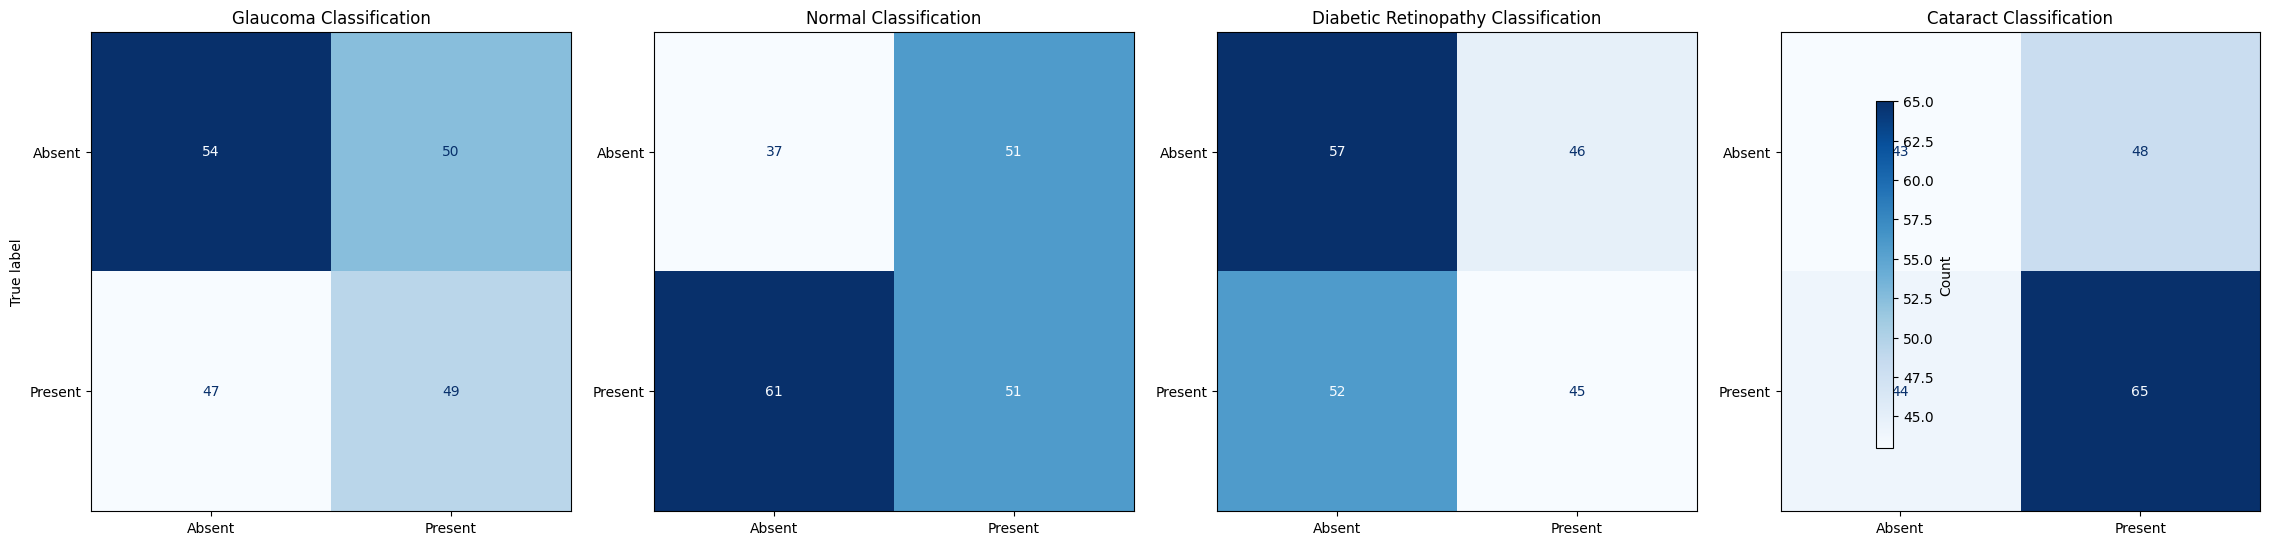

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

num_samples = 200
np.random.seed(42) 
y_test = np.random.randint(0, 2, size=(num_samples, 4)) 
y_pred_test = np.random.rand(num_samples, 4)

class_names = ['Glaucoma', 'Normal', 'Diabetic Retinopathy', 'Cataract']
num_classes = len(class_names)
f, axes = plt.subplots(1, num_classes, figsize=(num_classes * 6, 6)) 
axes = axes.ravel()
for i in range(num_classes):
   
    y_pred_binary_for_class_i = (y_pred_test[:, i] > 0.5).astype(int)
    cm = confusion_matrix(y_true=y_test[:, i], y_pred=y_pred_binary_for_class_i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Absent', 'Present'])
    disp.plot(ax=axes[i], values_format='d', cmap='Blues')

    disp.ax_.set_title(f'{class_names[i]} Classification')
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()


plt.subplots_adjust(wspace=0.10, hspace=0.1)
cbar = f.colorbar(disp.im_, ax=axes.tolist(), shrink=0.75, pad=0.01)
cbar.set_label('Count') 
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()
